In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from skimage import io

import torchvision.transforms as T
from PIL import Image
from torchvision.utils import make_grid
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot  as plt
import torchvision
from torch.autograd import Variable
import torch.nn as nn
from tqdm import tqdm

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256)),
    transforms.Normalize([0.5, 0.5, 0.5] , [0.5, 0.5, 0.5])
])

In [4]:
transformer_128 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128,128)),
    transforms.Normalize([0.5, 0.5, 0.5] , [0.5, 0.5, 0.5])
])

In [5]:
class LPDataset(Dataset):
    def __init__(self, csv_file, root_dir):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        Blur_image_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(Blur_image_path)
        image = transformer(image)
        Main_image_path = os.path.join("DATA", "Main_image", self.annotations.iloc[index, 1])
        T_image = io.imread(Main_image_path)
        T_image = transformer(T_image)
        return (image, T_image)
    

In [5]:
# class LPDataset_val(Dataset):
#     def __init__(self, csv_file, root_dir):
#         self.annotations = pd.read_csv(csv_file)
#         self.root_dir = root_dir
        
#     def __len__(self):
#         return len(self.annotations)
    
#     def __getitem__(self, index):
#         Blur_image_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
#         image = io.imread(Blur_image_path)
#         image = transformer(image)
#         Main_image_path = os.path.join("DATA", "Main_image", self.annotations.iloc[index, 1])
#         T_image = io.imread(Main_image_path)
#         T_image = transformer(T_image)
#         return (image, T_image)
    

In [6]:
train_data = LPDataset(csv_file='ES_data.csv', root_dir='DATA/Blur')
val_data = LPDataset(csv_file='ES_data_val.csv', root_dir='DATA/Blur')

In [7]:
small_test_data = LPDataset(csv_file='test_small_data.csv', root_dir='DATA/Blur')

In [8]:
small_test_dataloader = DataLoader(
    small_test_data,
    batch_size = 32,
    shuffle= True
)

In [9]:
train_dataloader = DataLoader(
    train_data,
    batch_size = 32,
    shuffle= True
)

In [10]:
val_dataloader = DataLoader(
    val_data,
    batch_size = 32,
    shuffle= True
)

torch.Size([32, 3, 256, 256]) torch.Size([32, 3, 256, 256])


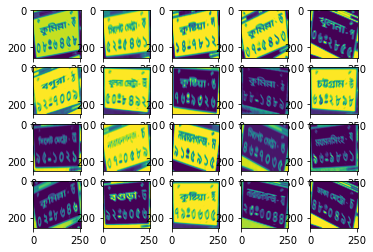

150


In [11]:
example = iter(train_dataloader)
image, T_image = example.next()
print(image.shape, T_image.shape)
for i in range(20):
    plt.subplot(4,5, i+1)
    plt.imshow(image[i][0])
plt.show()
print(len(train_dataloader))

torch.Size([32, 3, 256, 256]) torch.Size([32, 3, 256, 256])


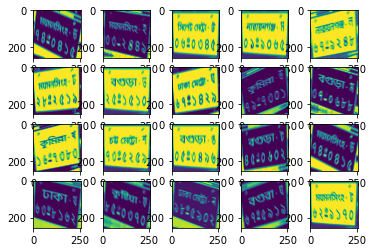

38


In [12]:
example = iter(val_dataloader)
image, T_image = example.next()
print(image.shape, T_image.shape)
for i in range(20):
    plt.subplot(4,5, i+1)
    plt.imshow(image[i][0])
plt.show()
print(len(val_dataloader))

In [14]:
class Autoencoder_03(torch.nn.Module):
    def __init__(self):
        super().__init__()        
        
        self.encoder = torch.nn.Sequential(
            nn.Conv2d(3, 6, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(6, 12, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(24, 48, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(48, 96, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(96, 512, 4, stride=2)
            
        )
        
        
        self.decoder = torch.nn.Sequential(
            nn.ConvTranspose2d(512, 96, 4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(96, 48, 4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(48, 24, 4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(12, 6, 4, stride=2,output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(6, 3, 4, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded



In [16]:
model = Autoencoder_03()
model = model.to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [25]:
num_epochs = 200
early_stopping = 15
best_loss = float('inf')
counter = 0

best_epoch = 0
best_epoch_train_loss = float('inf')
best_epoch_val_loss = float('inf')

train_loss_arr = []
val_loss_arr = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for (_,[image, T_image]) in tqdm(enumerate(train_dataloader)):

        image = image.to(device)
        T_image = T_image.to(device)
        
        out = model(image)
        loss = criterion(out, T_image)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss +=loss.cpu().data
    train_loss /= len(train_dataloader)  
    train_loss_arr.append(train_loss)

    model.eval()
    val_loss = 0
    for (_, [image, T_image]) in tqdm(enumerate(val_dataloader)):

        image = image.to(device)
        T_image = T_image.to(device)
        
        out = model(image)
        v_loss = criterion(out, T_image)
        val_loss +=v_loss.cpu().data
    val_loss /= len(val_dataloader)  
    val_loss_arr.append(val_loss)
    
    print(f'Epoch {epoch+1}: train loss = {train_loss:.4f}, val loss = {val_loss:.4f}')
    if epoch > 19:
        if val_loss < best_loss:
            best_loss = val_loss
            best_epoch = epoch+1
            best_epoch_train_loss = train_loss
            best_epoch_val_loss = val_loss
            
            counter = 0
            # Save the best model

            torch.save(model.state_dict(), 'best_model_stat/best_model_3.pt')
        else:
            counter += 1

        # Stop the training if the stopping criterion is met
        if counter >= early_stopping:
            print(f'Early stopping at epoch {epoch+1}')
            break
            
model.load_state_dict(torch.load('best_model_stat/best_model_3.pt'))

150it [05:24,  2.16s/it]
38it [01:18,  2.06s/it]


Epoch 1: train loss = 0.5143, val loss = 0.4438


150it [05:22,  2.15s/it]
38it [01:19,  2.08s/it]


Epoch 2: train loss = 0.4290, val loss = 0.4051


150it [05:23,  2.16s/it]
38it [01:20,  2.11s/it]


Epoch 3: train loss = 0.4057, val loss = 0.3899


150it [05:24,  2.17s/it]
38it [01:20,  2.11s/it]


Epoch 4: train loss = 0.3968, val loss = 0.3860


150it [05:25,  2.17s/it]
38it [01:20,  2.11s/it]


Epoch 5: train loss = 0.3798, val loss = 0.3465


150it [05:25,  2.17s/it]
38it [01:19,  2.10s/it]


Epoch 6: train loss = 0.3530, val loss = 0.3427


150it [05:25,  2.17s/it]
38it [01:20,  2.11s/it]


Epoch 7: train loss = 0.3509, val loss = 0.3423


150it [05:24,  2.16s/it]
38it [01:19,  2.10s/it]


Epoch 8: train loss = 0.3485, val loss = 0.3401


150it [05:22,  2.15s/it]
38it [01:19,  2.09s/it]


Epoch 9: train loss = 0.3471, val loss = 0.3402


150it [05:25,  2.17s/it]
38it [01:20,  2.12s/it]


Epoch 10: train loss = 0.3458, val loss = 0.3401


150it [05:23,  2.16s/it]
38it [01:19,  2.10s/it]


Epoch 11: train loss = 0.3444, val loss = 0.3384


150it [05:26,  2.17s/it]
38it [01:20,  2.13s/it]


Epoch 12: train loss = 0.3488, val loss = 0.3378


150it [05:24,  2.16s/it]
38it [01:18,  2.08s/it]


Epoch 13: train loss = 0.3429, val loss = 0.3370


150it [05:22,  2.15s/it]
38it [01:19,  2.08s/it]


Epoch 14: train loss = 0.3422, val loss = 0.3373


150it [05:21,  2.14s/it]
38it [01:19,  2.08s/it]


Epoch 15: train loss = 0.3414, val loss = 0.3359


150it [05:22,  2.15s/it]
38it [01:18,  2.08s/it]


Epoch 16: train loss = 0.3410, val loss = 0.3368


150it [05:22,  2.15s/it]
38it [01:18,  2.07s/it]


Epoch 17: train loss = 0.3410, val loss = 0.3352


150it [05:21,  2.15s/it]
38it [01:19,  2.08s/it]


Epoch 18: train loss = 0.3400, val loss = 0.3363


150it [05:22,  2.15s/it]
38it [01:18,  2.06s/it]


Epoch 19: train loss = 0.3399, val loss = 0.3379


150it [05:24,  2.16s/it]
38it [01:19,  2.09s/it]


Epoch 20: train loss = 0.3391, val loss = 0.3356


150it [05:22,  2.15s/it]
38it [01:19,  2.08s/it]


Epoch 21: train loss = 0.3388, val loss = 0.3364


150it [05:25,  2.17s/it]
38it [01:19,  2.08s/it]


Epoch 22: train loss = 0.3400, val loss = 0.3367


150it [2:02:40, 49.07s/it] 
38it [01:19,  2.08s/it]


Epoch 23: train loss = 0.3384, val loss = 0.3352


150it [05:21,  2.15s/it]
38it [01:18,  2.06s/it]


Epoch 24: train loss = 0.3378, val loss = 0.3351


150it [05:23,  2.15s/it]
38it [01:19,  2.08s/it]


Epoch 25: train loss = 0.3376, val loss = 0.3353


150it [05:24,  2.16s/it]
38it [01:18,  2.08s/it]


Epoch 26: train loss = 0.3378, val loss = 0.3349


150it [05:24,  2.16s/it]
38it [01:19,  2.08s/it]


Epoch 27: train loss = 0.3375, val loss = 0.3364


150it [05:25,  2.17s/it]
38it [01:18,  2.07s/it]


Epoch 28: train loss = 0.3371, val loss = 0.3355


150it [05:23,  2.15s/it]
38it [01:18,  2.08s/it]


Epoch 29: train loss = 0.3368, val loss = 0.3348


150it [05:24,  2.17s/it]
38it [01:19,  2.08s/it]


Epoch 30: train loss = 0.3367, val loss = 0.3347


150it [05:24,  2.16s/it]
38it [01:18,  2.07s/it]


Epoch 31: train loss = 0.3366, val loss = 0.3348


150it [05:23,  2.15s/it]
38it [01:19,  2.08s/it]


Epoch 32: train loss = 0.3365, val loss = 0.3350


150it [05:23,  2.16s/it]
38it [01:18,  2.07s/it]


Epoch 33: train loss = 0.3365, val loss = 0.3344


150it [05:23,  2.16s/it]
38it [01:18,  2.07s/it]


Epoch 34: train loss = 0.3365, val loss = 0.3355


150it [05:22,  2.15s/it]
38it [01:19,  2.08s/it]


Epoch 35: train loss = 0.3363, val loss = 0.3364


150it [05:31,  2.21s/it]
38it [01:21,  2.15s/it]


Epoch 36: train loss = 0.3365, val loss = 0.3348


150it [05:40,  2.27s/it]
38it [01:24,  2.21s/it]


Epoch 37: train loss = 0.3358, val loss = 0.3352


150it [05:37,  2.25s/it]
38it [01:27,  2.31s/it]


Epoch 38: train loss = 0.3358, val loss = 0.3347


150it [05:50,  2.34s/it]
38it [01:19,  2.10s/it]


Epoch 39: train loss = 0.3360, val loss = 0.3343


150it [05:20,  2.13s/it]
38it [01:19,  2.09s/it]


Epoch 40: train loss = 0.3355, val loss = 0.3355


150it [05:23,  2.16s/it]
38it [01:19,  2.10s/it]


Epoch 41: train loss = 0.3354, val loss = 0.3354


150it [05:26,  2.18s/it]
38it [01:21,  2.14s/it]


Epoch 42: train loss = 0.3354, val loss = 0.3354


150it [05:19,  2.13s/it]
38it [01:17,  2.05s/it]


Epoch 43: train loss = 0.3353, val loss = 0.3356


150it [05:16,  2.11s/it]
38it [01:17,  2.04s/it]


Epoch 44: train loss = 0.3363, val loss = 0.3387


150it [05:17,  2.11s/it]
38it [01:17,  2.04s/it]


Epoch 45: train loss = 0.3359, val loss = 0.3351


150it [05:16,  2.11s/it]
38it [01:17,  2.04s/it]


Epoch 46: train loss = 0.3349, val loss = 0.3356


150it [05:17,  2.11s/it]
38it [01:16,  2.02s/it]


Epoch 47: train loss = 0.3350, val loss = 0.3364


150it [05:16,  2.11s/it]
38it [01:17,  2.04s/it]


Epoch 48: train loss = 0.3349, val loss = 0.3358


150it [05:17,  2.12s/it]
38it [01:17,  2.04s/it]


Epoch 49: train loss = 0.3349, val loss = 0.3348


150it [05:17,  2.12s/it]
38it [01:18,  2.06s/it]


Epoch 50: train loss = 0.3348, val loss = 0.3355


150it [05:18,  2.13s/it]
38it [01:18,  2.06s/it]


Epoch 51: train loss = 0.3351, val loss = 0.3352


150it [05:21,  2.14s/it]
38it [01:18,  2.07s/it]


Epoch 52: train loss = 0.3351, val loss = 0.3344


150it [05:29,  2.20s/it]
38it [01:22,  2.18s/it]


Epoch 53: train loss = 0.3346, val loss = 0.3351


150it [05:40,  2.27s/it]
38it [01:22,  2.18s/it]

Epoch 54: train loss = 0.3346, val loss = 0.3346
Early stopping at epoch 54


<All keys matched successfully>

# Test model


In [13]:

class Autoencoder_Test(torch.nn.Module):
    def __init__(self):
        super().__init__()        
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded



In [26]:
model_test = Autoencoder_Test()
model_test = model_test.to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_test.parameters(), lr=0.001)

In [21]:
num_epochs = 5
early_stopping = 2
best_loss = float('inf')
counter = 0

train_loss_arr = []
val_loss_arr = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for (_,[image, T_image]) in tqdm(enumerate(small_test_dataloader)):

        image = image.to(device)
        T_image = T_image.to(device)
        
        out = model_test(image)
        loss = criterion(out, T_image)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss +=loss.cpu().data
    train_loss /= len(small_test_dataloader)  
    train_loss_arr.append(train_loss)

    model.eval()
    val_loss = 0
    for (_, [image, T_image]) in tqdm(enumerate(small_test_dataloader)):

        image = image.to(device)
        T_image = T_image.to(device)
        
        out = model_test(image)
        v_loss = criterion(out, T_image)
        val_loss +=v_loss.cpu().data
    val_loss /= len(small_test_dataloader)  
    val_loss_arr.append(val_loss)
    
    print(f'Epoch {epoch+1}: train loss = {train_loss:.4f}, val loss = {val_loss:.4f}')
    if epoch > 19:
        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
            # Save the best model

#             torch.save(model.state_dict(), 'best_model_stat/best_model.pt')
        else:
            counter += 1

        # Stop the training if the stopping criterion is met
        if counter >= early_stopping:
            print(f'Early stopping at epoch {epoch+1}')
            break
            
# model.load_state_dict(torch.load('best_model_stat/best_model.pt'))

4it [00:09,  2.31s/it]
4it [00:06,  1.58s/it]


Epoch 1: train loss = 0.7370, val loss = 0.7100


4it [00:06,  1.63s/it]
4it [00:06,  1.57s/it]


Epoch 2: train loss = 0.7265, val loss = 0.7886


4it [00:06,  1.65s/it]
4it [00:06,  1.56s/it]


Epoch 3: train loss = 0.7295, val loss = 0.7451


4it [00:06,  1.66s/it]
4it [00:06,  1.57s/it]


Epoch 4: train loss = 0.7486, val loss = 0.7697


4it [00:06,  1.60s/it]
4it [00:06,  1.58s/it]

Epoch 5: train loss = 0.7568, val loss = 0.7771


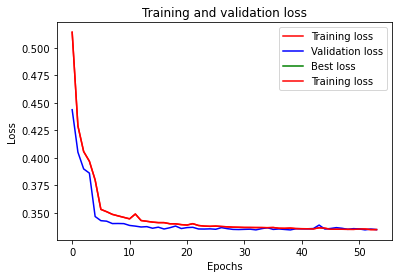

In [54]:
plt.plot( train_loss_arr, 'r', label='Training loss')
plt.plot(val_loss_arr, 'b', label='Validation loss')

plt.plot(best_epoch_train_loss, 'g', label='Best loss')
plt.plot( train_loss_arr, 'r', label='Training loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:

# epoch = [12, 12,23,345]
# sum = 0
# print_screen = tqdm(list(epoch))
# for i in print_screen:
#     print_screen.set_description("holadfgdfg hsd sfg sdf gsfg s df gsdf gsfg gh fg d ")

In [14]:
def PredictionCNN(image_path , transformer):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.show()
    image_tensor = transformer(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    image_tensor.to(device)
       
        
    input = Variable(image_tensor).to(device)

    output = model_test_128(input)
    output = output.cpu()
    
    
    plt.imshow(output[0].permute(1, 2, 0).detach().numpy())
    plt.show()
    
    return output.size()

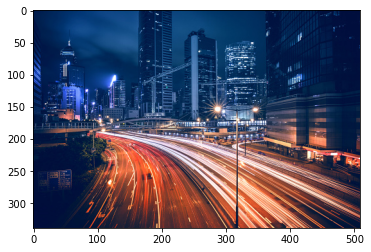

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


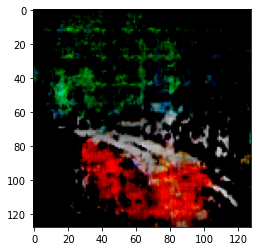

torch.Size([1, 3, 128, 128])

In [42]:
PredictionCNN("G:/CSE_499a/jupyter/DeBlur/try01/istockphoto-480496478-170667a.jpg", transformer_128)

In [35]:
# model04 = Autoencoder_03()
# model04 = model04.to(device)

# model04.load_state_dict(torch.load('best_model_stat/best_model.pt'))
# model04.eval()

In [ ]:
# torch.cuda.empty_cache()

In [26]:
best_epoch

39

In [27]:
best_epoch_train_loss

tensor(0.3360)

In [28]:
best_epoch_val_loss

tensor(0.3343)

In [41]:
model_test = Autoencoder_03()
model_test = model_test.to(device)

model_test.load_state_dict(torch.load('best_model_stat/best_model.pt'))
model.eval()

Autoencoder_03(
  (encoder): Sequential(
    (0): Conv2d(3, 6, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(6, 12, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(24, 48, kernel_size=(4, 4), stride=(2, 2))
    (7): ReLU()
    (8): Conv2d(48, 96, kernel_size=(4, 4), stride=(2, 2))
    (9): ReLU()
    (10): Conv2d(96, 512, kernel_size=(4, 4), stride=(2, 2))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(512, 96, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(96, 48, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(48, 24, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
    (6): ConvTranspose2d(24, 12, kernel_size=(4, 4), stride=(2, 2))
    (7): ReLU()
    (8): ConvTranspose2d(12, 6, kernel_size=(4, 4), stride=(2, 2), output_padding=(1, 1))
    (9): ReLU()
    (10): ConvTranspose2d(6, 3, kernel_size=(4, 4), st

In [15]:
model_test_128 = Autoencoder_Test()
model_test_128 = model_test_128.to(device)

model_test_128.load_state_dict(torch.load('best_model_stat/best_model_3.pt'))
model_test_128.eval()

Autoencoder_Test(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (7): ReLU()
  )
)